# Explainability Analysis

This notebook performs explainability analysis using LIME on the best-performing model:

Feature Selection: **Mutual Information Regression (MIR)**  
Model: **Logistic Regression**

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

BASE_DIR = Path.cwd().parents[1]
DATA_DIR = BASE_DIR / "features" / "03 - Third Working" / "mir"
MODEL_PATH = BASE_DIR / "models" / "03 - Third Working" / "Machine Learning" / "mir" / "logistic_regression.pkl"
OUT_FIG_DIR = BASE_DIR / "figures" / "Explainability Analysis"
OUT_CSV_DIR = BASE_DIR / "results" / "Explainability Analysis"

os.makedirs(OUT_FIG_DIR, exist_ok=True)
os.makedirs(OUT_CSV_DIR, exist_ok=True)

## Load Dataset & Model

In [2]:
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df = pd.read_csv(f"{DATA_DIR}/test.csv")

model = joblib.load(MODEL_PATH)

TARGET = "DepressionEncoded"

X_train = train_df.drop(columns=[TARGET])
y_train = train_df[TARGET]

X_test = test_df.drop(columns=[TARGET])
y_test = test_df[TARGET]

print("Training Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

Training Shape: (1617, 13)
Test Shape: (405, 13)


## Feature Names & Labels

In [3]:
feature_names = X_train.columns.tolist()

class_names = [
    "Minimal",
    "Mild",
    "Moderate",
    "Moderately Severe",
    "Severe"
]

## Initialize LIME Explainer

In [4]:
explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    discretize_continuous=True,
    mode="classification"
)

## Select Exactly One Sample Per Class

In [5]:
selected_samples = {}

for class_id in range(5):
    idx = y_test[y_test == class_id].index[0]
    selected_samples[class_id] = X_test.loc[idx].values

selected_samples

{0: array([ 0.51621365,  0.48402903, -2.01049357,  0.55104847, -1.20987992,
        -2.39048943,  1.6828033 , -0.76930919, -1.66811066, -2.01046724,
        -0.62400126, -1.02884976, -1.43891465]),
 1: array([-0.30115832, -0.37298209, -1.14610531, -0.29691196, -0.36103287,
        -0.6248019 , -0.1619396 , -0.76930919, -0.73636487, -0.98442869,
        -0.62400126, -0.15291956, -0.48184708]),
 2: array([ 0.51621365, -0.37298209,  0.58267122,  1.39900889,  0.48781418,
         0.25804187,  0.76043185,  0.1968667 , -0.73636487,  0.04160987,
        -0.62400126, -0.15291956,  0.4752205 ]),
 3: array([-0.30115832,  0.48402903,  1.44705948,  0.55104847, -1.20987992,
         1.14088564, -0.1619396 ,  1.16304258,  0.19538092,  1.06764843,
         1.32311379, -1.02884976, -0.48184708]),
 4: array([-0.30115832, -0.37298209, -0.28171704, -0.29691196, -0.36103287,
         1.14088564, -0.1619396 ,  1.16304258,  1.12712671,  1.06764843,
         1.32311379, -1.02884976, -0.48184708])}

## Run LIME Explainability for Each Class

d:\Programming\Projects\Depression Severity Assessment\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


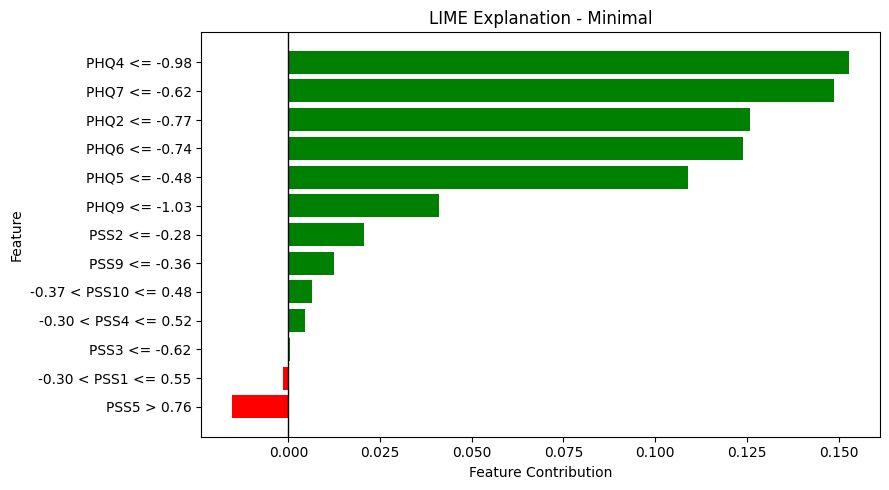

✅ LIME completed for class: Minimal


d:\Programming\Projects\Depression Severity Assessment\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


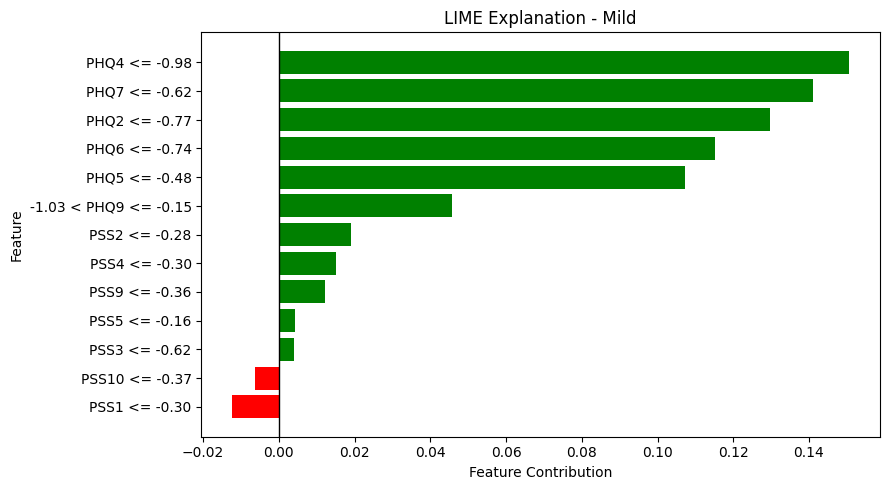

✅ LIME completed for class: Mild


d:\Programming\Projects\Depression Severity Assessment\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


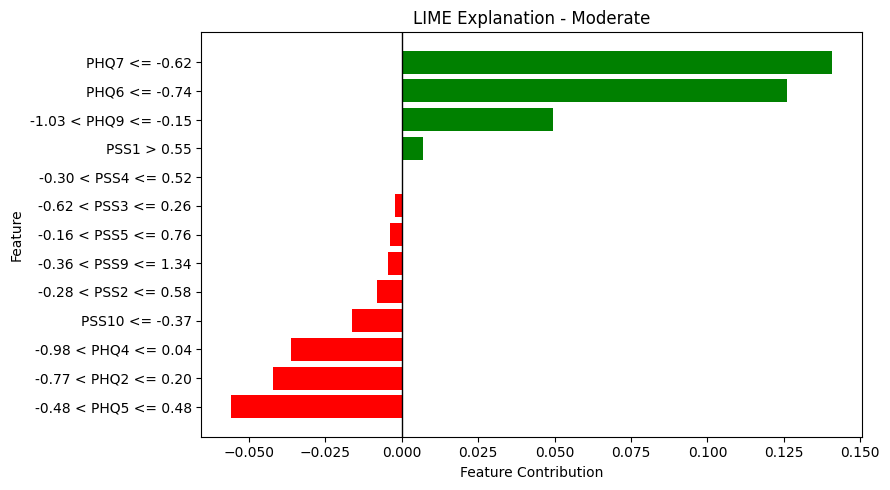

d:\Programming\Projects\Depression Severity Assessment\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ LIME completed for class: Moderate


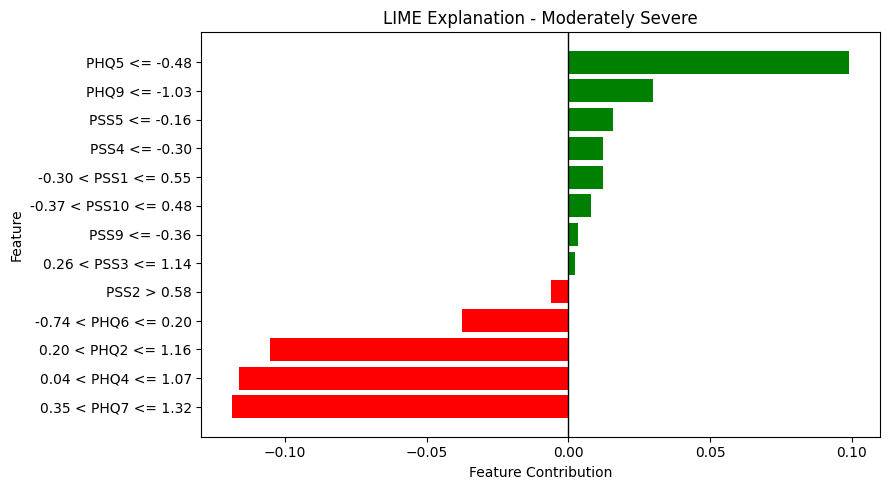

✅ LIME completed for class: Moderately Severe


d:\Programming\Projects\Depression Severity Assessment\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


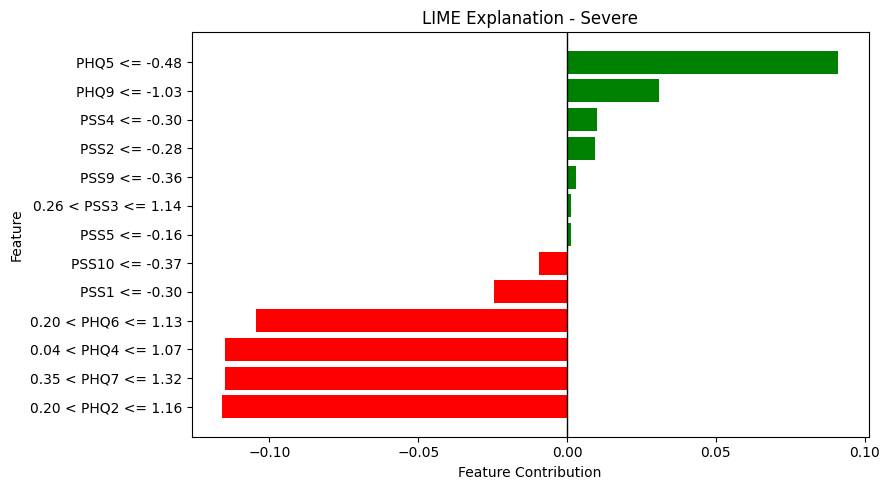

✅ LIME completed for class: Severe


In [6]:
summary_rows = []

for class_id, instance in selected_samples.items():

    exp = explainer.explain_instance(
        instance,
        model.predict_proba,
        num_features=13
    )

    class_name = class_names[class_id]

    html_path = f"{OUT_CSV_DIR}/lime_{class_name.lower().replace(' ', '_')}_{class_id}.html"
    exp.save_to_file(html_path)

    weights = pd.DataFrame(exp.as_list(), columns=["Feature", "Weight"])
    csv_path = f"{OUT_CSV_DIR}/lime_{class_name.lower().replace(' ', '_')}_{class_id}_weights.csv"
    weights.to_csv(csv_path, index=False)

    plt.figure(figsize=(9, 5))

    weights_sorted = weights.sort_values(by="Weight")
    colors = ["green" if val > 0 else "red" for val in weights_sorted["Weight"]]

    plt.barh(
        weights_sorted["Feature"],
        weights_sorted["Weight"],
        color=colors
    )

    plt.axvline(0, color="black", linewidth=1)
    plt.title(f"LIME Explanation - {class_name}")
    plt.xlabel("Feature Contribution")
    plt.ylabel("Feature")
    plt.tight_layout()

    png_path = f"{OUT_FIG_DIR}/lime_{class_name.lower().replace(' ', '_')}_{class_id}.png"
    plt.savefig(png_path)
    plt.show()
    plt.close()

    weights["Class"] = class_name
    summary_rows.append(weights)

    print(f"✅ LIME completed for class: {class_name}")

## Save Global Summary Across All Classes

In [7]:
lime_summary = pd.concat(summary_rows)

summary_path = f"{BASE_DIR / "summary" / "results" / "Explainability Analysis"}/lime_mir_summary.csv"
lime_summary.to_csv(summary_path, index=False)

lime_summary.head()

,Feature,Weight,Class
0,PHQ4 <= -0.98,0.152903,Minimal
1,PHQ7 <= -0.62,0.148740,Minimal
2,PHQ2 <= -0.77,0.125818,Minimal
3,PHQ6 <= -0.74,0.124009,Minimal
4,PHQ5 <= -0.48,0.108838,Minimal
